In [3]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from matplotlib.ticker import AutoMinorLocator
from matplotlib.animation import FuncAnimation
from scipy.integrate import odeint
from scipy.fftpack import fft, fftfreq, fftshift
from scipy.signal import find_peaks
# from nolds import lyap_r
from scipy.integrate import solve_ivp
from functools import partial


plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({'figure.autolayout': True})


# To produce data for Fig. 3(c) of main text and Fig. S2(d-f) of Appendix

In [4]:
def vectorfield_B( t, m,p):
    """
    Defines the system of differential equations based on Model B.
    
    Arguments:
        w : vector of the state variables
            w = [xA, pA, xB, pB]
        t : time
        p : vector of parameters
            p = [OmegaA, OmegaB, Gamma]
    """
    
    [xA, pA, xB, pB] = m[0:4]

    Sigma = m[4:].reshape(4,4)
    
    Omega, Kappa, U, Mu, nth = p

    Eb = xB**2 + pB**2

    Ea = xA**2 + pA**2

    A = np.array([ [ 2*U*xA*pA, U * (Ea + 2*pA**2) - Mu, 0, Omega/2 ], [ -U * (Ea + 2*xA**2) + Mu, -2*U*xA*pA, -Omega/2, 0 ], [0 , Omega/2, 2*U*xB*pB, U * (Eb + 2*pB**2) - Mu], [-Omega/2, 0, -U * (Eb + 2*xB**2) + Mu, -2*U*xB*pB] ])

    Q = (Kappa/4) * np.array([ [-Eb, 0, -2*xA*xB, -2*xA*pB],[0, -Eb, -2*pA*xB, -2*pA*pB],[2*xA*xB, 2*pA*xB, Ea, 0],[2*xA*pB, 2*pA*pB, 0, Ea] ] )

    Zp= (2*nth+1)*(Kappa/4) * np.array([ [Eb, 0, pA*pB-xA*xB, -(xA*pB+xB*pA)], [0, Eb, -(xA*pB+xB*pA), xA*xB-pA*pB], [pA*pB-xA*xB, -(xA*pB+xB*pA), Ea, 0], [-(xA*pB+xB*pA), xA*xB-pA*pB, 0, Ea] ] ) 
    
    dxa =  Omega * pB/2 - kappa * xA * Eb / 4 + U * pA * Ea - Mu * pA
    
    dpa = -Omega * xB/2 - kappa * pA * Eb / 4 - U * xA * Ea + Mu * xA
    
    dxb =  Omega * pA/2 + kappa * xB * Ea / 4 + U * pB * Eb - Mu * pB
    
    dpb = -Omega * xA/2 + kappa * pB * Ea / 4 - U * xB * Eb + Mu * xB

    dSigma = np.dot(A + Q, Sigma) + np.dot(Sigma, A.T + Q.T ) + Zp
    
    return np.concatenate(([dxa, dpa, dxb, dpb], dSigma.flatten()))


def funx(x):
    return (x+1)*np.log((x+1)/2)/2-(x-1)*np.log(np.abs((x-1)/2))/2

def entanglement(m0): 
    
    sym = np.array([[0,1,0,0],[-1,0,0,0],[0,0,0,1],[0,0,-1,0]])
    
    lamb = [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,-1]]
    
    sigma = m0.reshape(4,4)
    
    sigma_pt = np.dot(np.dot(lamb,sigma),lamb)
    eigs_pt = np.linalg.eigvals(2j*np.dot(sym,sigma_pt))
    eigs_pt_min = np.min(np.abs(eigs_pt))
    ent = np.max([0,-np.log(eigs_pt_min)])
    
    return ent

def discord_cl(m0): 
    
    sym=np.array([[0,1,0,0],[-1,0,0,0],[0,0,0,1],[0,0,-1,0]])
    
    sigma = m0.reshape(4,4)
    
    c_alpha = np.linalg.det(2*sigma[0:2,0:2])
    c_beta  = np.linalg.det(2*sigma[2:4,2:4])
    c_gamma = np.linalg.det(2*sigma[0:2,2:4:])
    c_delta = np.linalg.det(2*sigma)
    
    if (c_delta-c_alpha*c_beta)**2 <= (1+c_beta)*c_gamma**2*(c_alpha+c_delta):
        Emin = (2*c_gamma**2+(c_beta-1)*(c_delta-c_alpha)+2*np.abs(c_gamma)*np.sqrt(c_gamma**2+(c_beta-1)*(c_delta-c_alpha)))/(c_beta-1)**2
    else:
        Emin = (c_alpha*c_beta-c_gamma**2+c_delta-np.sqrt(c_gamma**4+(c_delta-c_alpha*c_beta)**2-2*c_gamma**2*(c_alpha*c_beta+c_delta)))/(2*c_beta)
    

    disc= funx(np.sqrt(c_alpha))-funx(np.sqrt(Emin))
    # print(c_alpha,Emin)

    return np.real(disc)

def discord_qm(m0): 

    sym=np.array([[0,1,0,0],[-1,0,0,0],[0,0,0,1],[0,0,-1,0]])
    
    sigma = m0.reshape(4,4)
    
    c_alpha = np.linalg.det(2*sigma[0:2,0:2])
    c_beta  = np.linalg.det(2*sigma[2:4,2:4])
    c_gamma = np.linalg.det(2*sigma[0:2,2:4:])
    c_delta = np.linalg.det(2*sigma)
    
    if (c_delta-c_alpha*c_beta)**2 <= (1+c_beta)*c_gamma**2*(c_alpha+c_delta):
        Emin = (2*c_gamma**2+(c_beta-1)*(c_delta-c_alpha)+2*np.abs(c_gamma)*np.sqrt(c_gamma**2+(c_beta-1)*(c_delta-c_alpha)))/(c_beta-1)**2
    else:
        Emin = (c_alpha*c_beta-c_gamma**2+c_delta-np.sqrt(c_gamma**4+(c_delta-c_alpha*c_beta)**2-2*c_gamma**2*(c_alpha*c_beta+c_delta)))/(2*c_beta)
    
    eigs=np.linalg.eigvals(2j*np.dot(sym,sigma))
    [v_m,v_p]=np.sort(eigs)[2:4]

    disc= funx(np.sqrt(c_beta))-funx(v_p)-funx(v_m)+funx(np.sqrt(Emin))
    return np.real(disc)

def pos(m0): 
    
    sym=np.array([[0,1,0,0],[-1,0,0,0],[0,0,0,1],[0,0,-1,0]])
    
    sigma = m0.reshape(4,4)
    
    return np.min(np.real(np.linalg.eigvals(sigma+1j*sym/2)))


def fourier_transform(data, dt):
    n = len(data)
    fft_result = np.fft.fft(data)
    fft_freq = np.fft.fftfreq(n, dt)
    return fft_freq, fft_result


In [5]:
eps=0.3

m0=[np.sqrt(2-eps**2),eps,np.sqrt(2-eps**2),eps]

sigma0=np.diag([1,1,1,1])/2

ini=np.concatenate((m0,sigma0.flatten()))

Omega = 1
kappa = 1

U = 0.
nth0=0
nth1=1
nth2=2
Mu = 0.

p0=[Omega,kappa,U,Mu,nth0]
p1=[Omega,kappa,U,Mu,nth1]
p2=[Omega,kappa,U,Mu,nth2]
# number of time steps
f_s = 10
end_time = 4000
time = np.linspace(0, end_time, end_time * f_s)

# ODE solver parameters
abserr = 1.0e-16
relerr = 1.0e-13
stoptime = 10.0
numpoints = 250

msol0=solve_ivp(partial(vectorfield_B, p=p0), (0, end_time), ini, method='RK45', t_eval=time, atol=abserr, rtol=relerr)
msol1=solve_ivp(partial(vectorfield_B, p=p1), (0, end_time), ini, method='RK45', t_eval=time, atol=abserr, rtol=relerr)
msol2=solve_ivp(partial(vectorfield_B, p=p2), (0, end_time), ini, method='RK45', t_eval=time, atol=abserr, rtol=relerr)

fft_freqA0, fft_resultA0 = fourier_transform(msol0.y[1,:], 1/f_s)
fft_freqB0, fft_resultB0 = fourier_transform(msol0.y[3,:], 1/f_s)

ent_time0=[]
pos_time0=[]
disc_qm0=[]
disc_cl0=[]
for i in range(1,len(time)):
    ent_time0.append(entanglement(msol0.y[4:,i]))
    pos_time0.append(pos(msol0.y[4:,i]))
    disc_qm0.append(discord_qm(msol0.y[4:,i]))
    disc_cl0.append(discord_cl(msol0.y[4:,i]))
    
fft_freqA1, fft_resultA1 = fourier_transform(msol1.y[1,:], 1/f_s)
fft_freqB1, fft_resultB1 = fourier_transform(msol1.y[3,:], 1/f_s)

ent_time1=[]
pos_time1=[]
disc_qm1=[]
disc_cl1=[]
for i in range(1,len(time)):
    ent_time1.append(entanglement(msol1.y[4:,i]))
    pos_time1.append(pos(msol1.y[4:,i]))
    disc_qm1.append(discord_qm(msol1.y[4:,i]))
    disc_cl1.append(discord_cl(msol1.y[4:,i]))

fft_freqA2, fft_resultA2 = fourier_transform(msol2.y[1,:], 1/f_s)
fft_freqB2, fft_resultB2 = fourier_transform(msol2.y[3,:], 1/f_s)

ent_time2=[]
pos_time2=[]
disc_qm2=[]
disc_cl2=[]
for i in range(1,len(time)):
    ent_time2.append(entanglement(msol2.y[4:,i]))
    pos_time2.append(pos(msol2.y[4:,i]))
    disc_qm2.append(discord_qm(msol2.y[4:,i]))
    disc_cl2.append(discord_cl(msol2.y[4:,i]))

In [6]:
ent_avg=np.loadtxt("ent_nth.dat") # load entanglement data 
qmD_avg=np.loadtxt("qmD_nth.dat") # load quantum discord data
clD_avg=np.loadtxt("clD_nth.dat") # load classical discord data
ent_U=np.loadtxt("ent_U.dat") # load entanglement data 
qmD_U=np.loadtxt("qmD_U.dat") # load quantum discord data
clD_U=np.loadtxt("clD_U.dat") # load classical discord data

# Plotting Fig. 3(a-c)

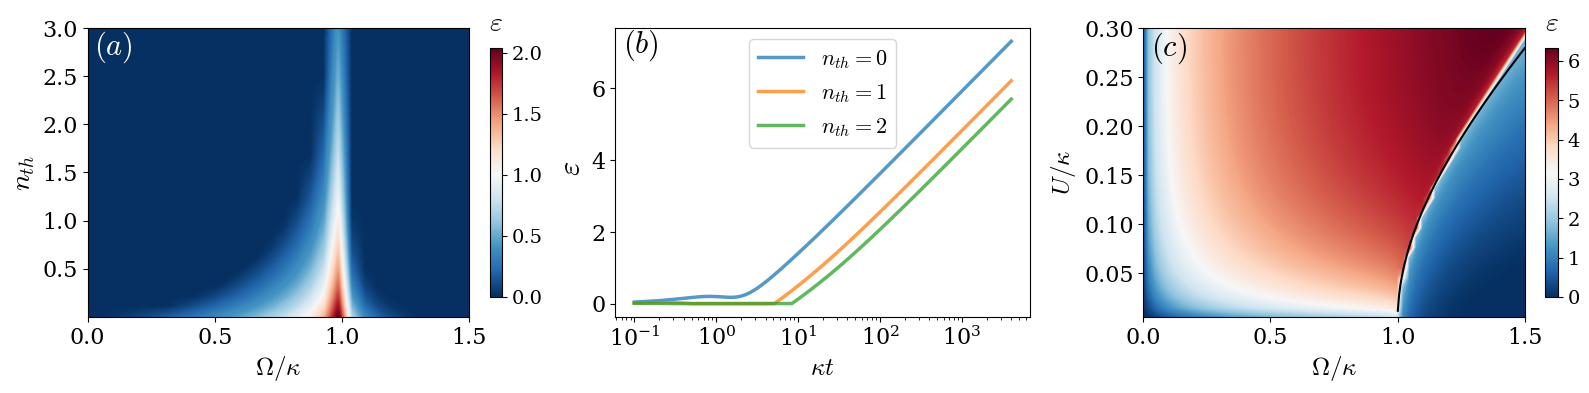

In [8]:
from matplotlib import cm

O_val=np.linspace(0,1.5,30)
n_val=np.linspace(0,3,30)
dd,tt=np.meshgrid(O_val,n_val)
OU_val=np.linspace(0,1.5,60)
U_val=np.linspace(-0.3,0.3,60)
ddU,ttU=np.meshgrid(OU_val,U_val[30:60])

f_s = 10
end_time = 4000
time = np.linspace(0, end_time, end_time * f_s)

fig, ax = plt.subplots(1, 3, figsize=(16,4))

k=0

im = ax[k].contourf(dd,tt,np.transpose(ent_avg),300,cmap='RdBu_r', vmin=0, vmax=np.max(ent_avg))
cbar = fig.colorbar(im, ax=ax[k], fraction=0.03)

# ax[k].plot(1,1,'Pk',markersize=10)
# ax[k].plot(1,2,'Xk',markersize=10)
# ax[k].plot(1,2.95,'^k',markersize=10)
# Set the ticks you want on the colorbar
cbar.set_ticks([0, 0.5, 1, 1.5, 2])
# cbar.set_ticklabels(['0', '0.5', '1', '1.5', '2', '2.5', '3'])
cbar.ax.tick_params(labelsize=14, color='black', labelcolor='black')
# cbar.set_label(r'$\varepsilon$', fontsize=18, labelpad=15)
# cbar.ax.xaxis.set_label_position('top')
cbar.ax.text(
   0.5, 1.1,  # Position (x, y) in axes coordinates
    r'$\varepsilon$',  # Text to display
    ha='center',  # Horizontal alignment
    va='center',  # Vertical alignment
    fontsize=20,  # Font size
    transform=cbar.ax.transAxes  # Use axes coordinates
)


# Optional: Set the edge color of each collection to the face color
for c in im.collections:
    c.set_edgecolor("face")

cbar.ax.tick_params(labelsize=14)
ax[k].set_xlabel(r'$\Omega/\kappa$', fontsize=18)
# ax[k].set_title(rf'Entanglement ($\varepsilon$)', fontsize=18)
ax[k].set_yticks([0.5,1,1.5,2,2.5,3])
ax[k].tick_params(labelsize=16)
ax[k].set_ylabel(r'$n_{th} $', fontsize=20)

ax[k].text(
    0.1, 2.8,  # Position (x, y) in figure coordinates
    r'$(a)$',  # Text to display
    ha='center',  # Horizontal alignment
    va='center',  # Vertical alignment
    fontsize=22,  # Font size
    color='white'
)

k=1

ax[k].semilogx(time[1:],ent_time0, lw=2.5, alpha=0.75,label=r'$n_{th}=0$')
ax[k].semilogx(time[1:],ent_time1, lw=2.5, alpha=0.75,label=r'$n_{th}=1$')
ax[k].semilogx(time[1:],ent_time2, lw=2.5, alpha=0.75,label=r'$n_{th}=2$')

ax[k].set_xlabel(r'$\kappa t$', fontsize=18)
ax[k].tick_params(labelsize=16)
ax[k].set_ylabel(r' $\varepsilon$', fontsize=22)
ax[k].legend(fontsize=16, loc='upper center')
ax[k].text(
    0.12, 7.2,  # Position (x, y) in figure coordinates
    r'$(b)$',  # Text to display
    ha='center',  # Horizontal alignment
    va='center',  # Vertical alignment
    fontsize=22  # Font size
#     color='white'
)


k=2
im = ax[k].contourf(ddU,ttU,np.transpose(ent_U[:,30:60]),300,cmap='RdBu_r', vmin=0, vmax=np.max(ent_U))
# ax[k].plot(Omega_vals,0.2*np.ones(len(Omega_vals)),'--w')
# ax[k].plot(Ω[0],0.2,'dw', markersize=10)
# ax[k].plot(Ω[1],0.2,'sw', markersize=10)
# ax[k].plot(Ω[2],0.2,'^w', markersize=10)

cbar = fig.colorbar(im, ax=ax[k], fraction=0.03)#, fraction=0.046, pad=0.04

# Set the ticks you want on the colorbar
cbar.set_ticks([0, 1, 2,3, 4, 5,6])
# cbar.set_ticklabels(['0', '0.5', '1', '1.5', '2', '2.5', '3'])
cbar.ax.tick_params(labelsize=14, color='black', labelcolor='black')
# cbar.set_label(r'$\varepsilon$', fontsize=18, labelpad=15)
# cbar.ax.xaxis.set_label_position('top')
cbar.ax.text(
   0.5, 1.1,  # Position (x, y) in axes coordinates
    r'$\varepsilon$',  # Text to display
    ha='center',  # Horizontal alignment
    va='center',  # Vertical alignment
    fontsize=20,  # Font size
    transform=cbar.ax.transAxes  # Use axes coordinates
    
)
Oo_val=np.linspace(1.001,1.5,100)
for c in im.collections:
    c.set_edgecolor("face")
cbar.ax.tick_params(labelsize=14)
ax[k].plot(Oo_val,np.sqrt(Oo_val**2-1)/4,'-k')
ax[k].set_xlabel(r'$\Omega/\kappa$', fontsize=18)
# ax[k].set_title(rf'Entanglement ($\varepsilon$)', fontsize=18)
ax[k].set_yticks([0.05,.1,.15,.2,.25,.3])
ax[k].tick_params(labelsize=16)
ax[k].set_ylabel(r'$U /\kappa$', fontsize=18)
ax[k].text(
    0.1, 0.28,  # Position (x, y) in figure coordinates
    r'$(c)$',  # Text to display
    ha='center',  # Horizontal alignment
    va='center',  # Vertical alignment
    fontsize=22  # Font size
#     color='white'
)

plt.tight_layout()
# plt.savefig('ent_btc_2.svg',dpi=300)
plt.show()

# Plotting Fig. S2

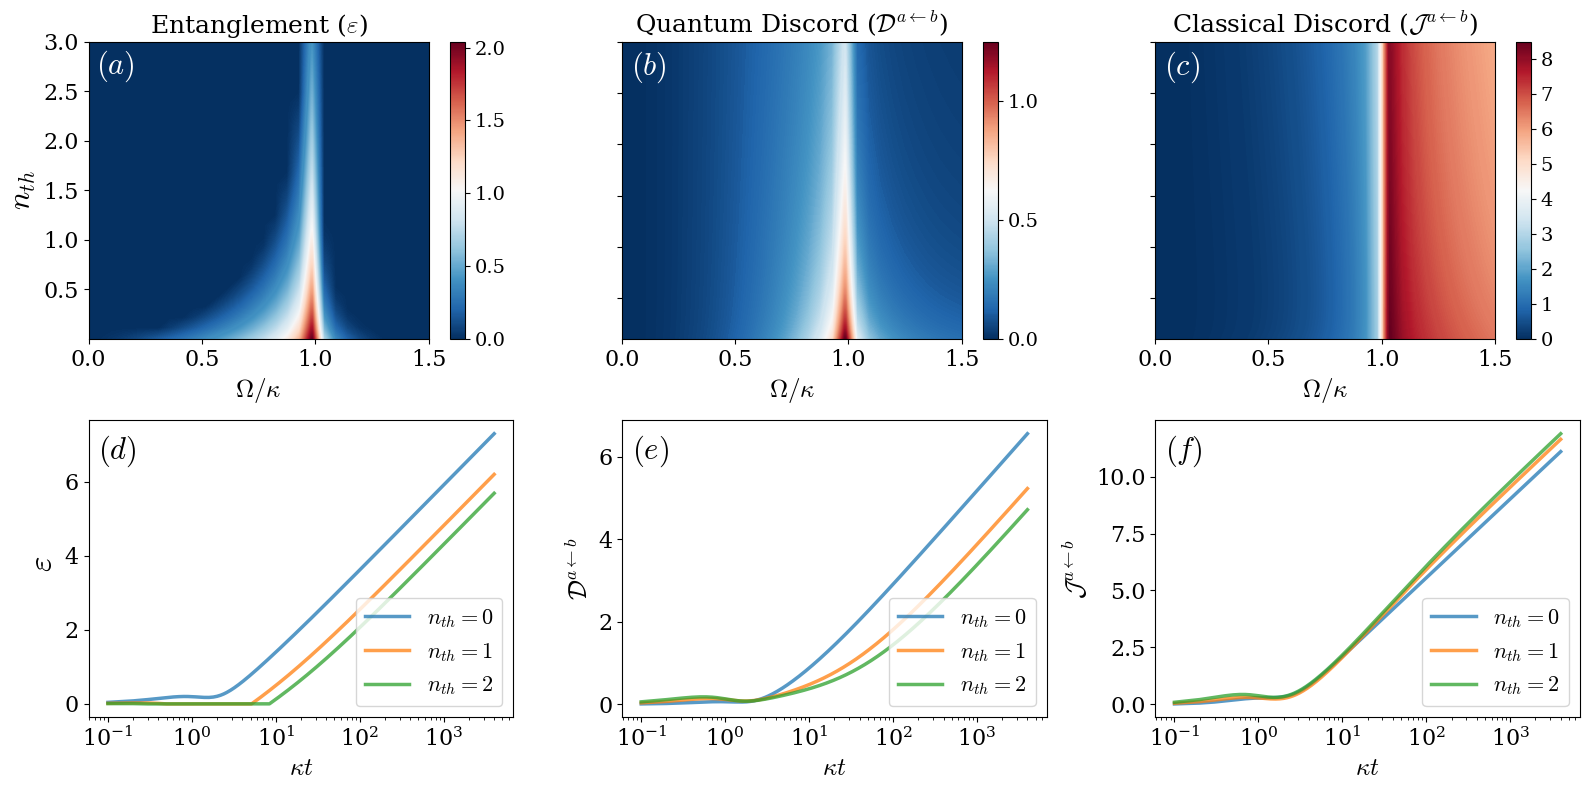

In [10]:
from matplotlib import cm

O_val=np.linspace(0,1.5,30)
n_val=np.linspace(0,3,30)
dd,tt=np.meshgrid(O_val,n_val)
OU_val=np.linspace(0,1.5,60)
U_val=np.linspace(-0.3,0.3,60)
ddU,ttU=np.meshgrid(OU_val,U_val[30:60])


f_s = 10
end_time = 4000
time = np.linspace(0, end_time, end_time * f_s)

fig, ax = plt.subplots(2, 3, figsize=(16,8))

k=0

im = ax[0,k].contourf(dd,tt,np.transpose(ent_avg),300,cmap='RdBu_r')
cbar=fig.colorbar(im, ax=ax[0,k])
for c in im.collections:
    c.set_edgecolor("face")
cbar.set_ticks([0, 0.5, 1, 1.5, 2])

cbar.ax.tick_params(labelsize=14)
ax[0,k].set_xlabel(r'$\Omega/\kappa$', fontsize=18)
ax[0,k].set_title(rf'Entanglement ($\varepsilon$)', fontsize=18)
ax[0,k].set_yticks([0.5,1,1.5,2,2.5,3])
ax[0,k].tick_params(labelsize=16)
ax[0,k].set_ylabel(r'$n_{th} $', fontsize=22)


k=1

im = ax[0,k].contourf(dd[1:,:],tt[1:,:],np.transpose(qmD_avg[:,1:]),300,cmap='RdBu_r')
cbar=fig.colorbar(im, ax=ax[0,k])
for c in im.collections:
    c.set_edgecolor("face")
cbar.ax.tick_params(labelsize=14)
cbar.set_ticks([0, 0.5, 1])

ax[0,k].set_xlabel(r'$\Omega/\kappa$', fontsize=18)
ax[0,k].set_title(r'Quantum Discord ($\mathcal{D}^{a \leftarrow b}$)', fontsize=18)
ax[0,k].set_yticks([0.5,1,1.5,2,2.5,3],['','','','','',''])
ax[0,k].tick_params(labelsize=16)
# ax[0,k].set_ylabel(r'$n_{th} $', fontsize=14)

k=2

im = ax[0,k].contourf(dd[1:,:],tt[1:,:],np.transpose(clD_avg[:,1:]),300,cmap='RdBu_r')
cbar=fig.colorbar(im, ax=ax[0,k])
for c in im.collections:
    c.set_edgecolor("face")
cbar.ax.tick_params(labelsize=14)
cbar.set_ticks([0, 1,2,3,4,5,6,7,8])

ax[0,k].set_xlabel(r'$\Omega/\kappa$', fontsize=18)
ax[0,k].set_title(r'Classical Discord ($\mathcal{J}^{a \leftarrow b}$)', fontsize=18)
ax[0,k].set_yticks([0.5,1,1.5,2,2.5,3],['','','','','',''])
ax[0,k].tick_params(labelsize=16)
# ax[0,k].set_ylabel(r'$n_{th} $', fontsize=14)


k=0
ax[1,k].semilogx(time[1:],ent_time0, lw=2.5, alpha=0.75,label=r'$n_{th}=0$')
ax[1,k].semilogx(time[1:],ent_time1, lw=2.5, alpha=0.75,label=r'$n_{th}=1$')
ax[1,k].semilogx(time[1:],ent_time2, lw=2.5, alpha=0.75,label=r'$n_{th}=2$')

ax[1,k].set_xlabel(r'$\kappa t$', fontsize=18)
ax[1,k].tick_params(labelsize=16)
ax[1,k].set_ylabel(r' $\varepsilon$', fontsize=24)
ax[1,k].legend(fontsize=16, loc = 'lower right')

k=1
ax[1,k].semilogx(time[1:],disc_qm0, lw=2.5, alpha=0.75,label=r'$n_{th}=0$')
ax[1,k].semilogx(time[1:],disc_qm1, lw=2.5, alpha=0.75,label=r'$n_{th}=1$')
ax[1,k].semilogx(time[1:],disc_qm2, lw=2.5, alpha=0.75,label=r'$n_{th}=2$')

ax[1,k].set_xlabel(r'$\kappa t$', fontsize=18)
ax[1,k].tick_params(labelsize=16)
ax[1,k].set_ylabel(r'$\mathcal{D}^{a \leftarrow b}$', fontsize=18)
ax[1,k].legend(fontsize=16, loc = 'lower right')

k=2
ax[1,k].semilogx(time[1:],disc_cl0, lw=2.5, alpha=0.75,label=r'$n_{th}=0$')
ax[1,k].semilogx(time[1:],disc_cl1, lw=2.5, alpha=0.75,label=r'$n_{th}=1$')
ax[1,k].semilogx(time[1:],disc_cl2, lw=2.5, alpha=0.75,label=r'$n_{th}=2$')

ax[1,k].set_xlabel(r'$\kappa t$', fontsize=18)
ax[1,k].tick_params(labelsize=16)
ax[1,k].set_ylabel(r'$\mathcal{J}^{a \leftarrow b}$', fontsize=18)
ax[1,k].legend(fontsize=16, loc = 'lower right')

ax[0,0].text(
    0.12, 2.75,  # Position (x, y) in figure coordinates
    r'$(a)$',  # Text to display
    ha='center',  # Horizontal alignment
    va='center',  # Vertical alignment
    fontsize=22,  # Font size
     color='white'
)

ax[0,1].text(
    0.12, 2.75,  # Position (x, y) in figure coordinates
    r'$(b)$',  # Text to display
    ha='center',  # Horizontal alignment
    va='center',  # Vertical alignment
    fontsize=22,  # Font size
     color='white'
)

ax[0,2].text(
    0.12, 2.75,  # Position (x, y) in figure coordinates
    r'$(c)$',  # Text to display
    ha='center',  # Horizontal alignment
    va='center',  # Vertical alignment
    fontsize=22,  # Font size
     color='white'
)

ax[1,0].text(
    0.13, 2.8*np.max(ent_time0)/3,  # Position (x, y) in figure coordinates
    r'$(d)$',  # Text to display
    ha='center',  # Horizontal alignment
    va='center',  # Vertical alignment
    fontsize=22,  # Font size
     color='black'
)

ax[1,1].text(
    0.13, 2.8*np.max(disc_qm0)/3,  # Position (x, y) in figure coordinates
    r'$(e)$',  # Text to display
    ha='center',  # Horizontal alignment
    va='center',  # Vertical alignment
    fontsize=22,  # Font size
     color='black'
)

ax[1,2].text(
    0.13,  2.8*np.max(disc_cl2)/3,  # Position (x, y) in figure coordinates
    r'$(f)$',  # Text to display
    ha='center',  # Horizontal alignment
    va='center',  # Vertical alignment
    fontsize=22,  # Font size
     color='black'
)
plt.tight_layout()
# plt.savefig('ent_BTC_limit.png',dpi=300)
plt.show()

# Plotting Fig. S3

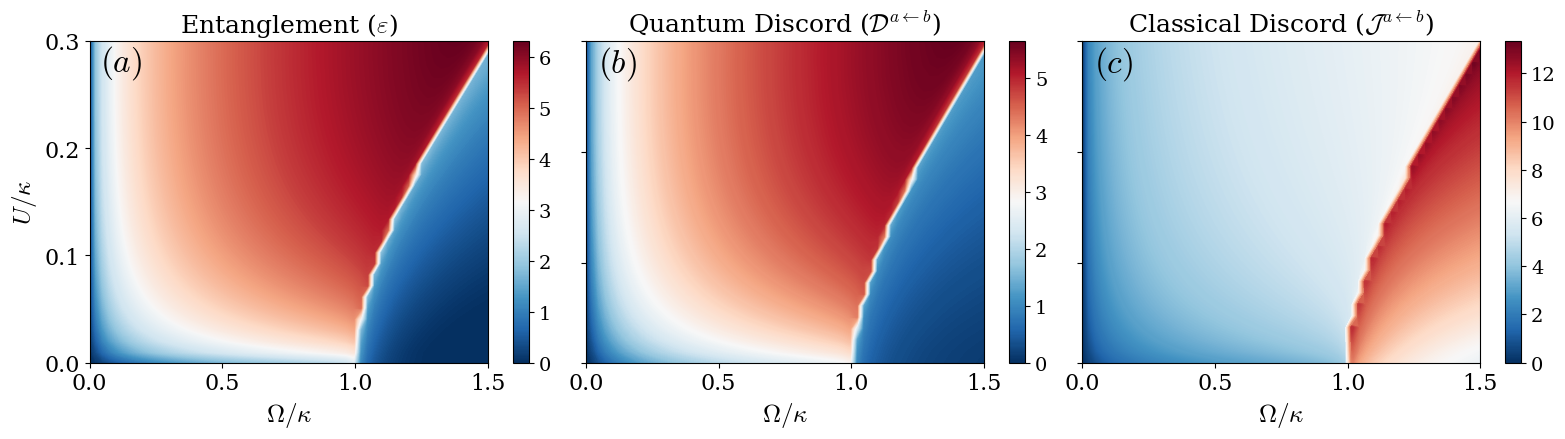

In [11]:
OU_val=np.linspace(0,1.5,60)
U_val=np.linspace(0,0.3,30)
ddU1,ttU1=np.meshgrid(OU_val,U_val)

from matplotlib import cm

# O_val=np.linspace(0,1.5,60)
# n_val=np.linspace(0,3,30)
# dd,tt=np.meshgrid(O_val,n_val)


f_s = 10
end_time = 4000
time = np.linspace(0, end_time, end_time * f_s)

fig, ax = plt.subplots(1, 3, figsize=(16,4.5))

k=0

im = ax[k].contourf(ddU1,ttU1,np.transpose(ent_U[:,30:60]),300,cmap='RdBu_r')
cbar=fig.colorbar(im, ax=ax[k])
for c in im.collections:
    c.set_edgecolor("face")
cbar.set_ticks([0, 1, 2, 3, 4, 5, 6])

cbar.ax.tick_params(labelsize=14)
ax[k].set_xlabel(r'$\Omega/\kappa$', fontsize=18)
ax[k].set_title(rf'Entanglement ($\varepsilon$)', fontsize=18)
ax[k].set_yticks([0,0.1,0.2,0.3])
ax[k].tick_params(labelsize=16)
ax[k].set_ylabel(r'$U/\kappa$', fontsize=18)


k=1

im = ax[k].contourf(ddU1[1:,:],ttU1[1:,:],np.transpose(qmD_U[:,31:60]),300,cmap='RdBu_r')
cbar=fig.colorbar(im, ax=ax[k])
for c in im.collections:
    c.set_edgecolor("face")
cbar.ax.tick_params(labelsize=14)
cbar.set_ticks([0, 1, 2, 3, 4, 5])

ax[k].set_xlabel(r'$\Omega/\kappa$', fontsize=18)
ax[k].set_title(r'Quantum Discord ($\mathcal{D}^{a \leftarrow b}$)', fontsize=18)
ax[k].set_yticks([0.01,0.1,0.2,0.3],['','','',''])
ax[k].tick_params(labelsize=16)
# ax[0,k].set_ylabel(r'$n_{th} $', fontsize=14)

k=2

im = ax[k].contourf(ddU1[1:,:],ttU1[1:,:],np.transpose(clD_U[:,31:60]),300,cmap='RdBu_r')
cbar=fig.colorbar(im, ax=ax[k])
for c in im.collections:
    c.set_edgecolor("face")
cbar.ax.tick_params(labelsize=14)
cbar.set_ticks([0, 2, 4, 6, 8, 10, 12])

ax[k].set_xlabel(r'$\Omega/\kappa$', fontsize=18)
ax[k].set_title(r'Classical Discord ($\mathcal{J}^{a \leftarrow b}$)', fontsize=18)
ax[k].set_yticks([0.01,0.1,0.2,0.3],['','','',''])
ax[k].tick_params(labelsize=16)
# ax[0,k].set_ylabel(r'$n_{th} $', fontsize=14)


ax[0].text(
    0.12, 0.28,  # Position (x, y) in figure coordinates
    r'$(a)$',  # Text to display
    ha='center',  # Horizontal alignment
    va='center',  # Vertical alignment
    fontsize=24,  # Font size
     color='black'
)

ax[1].text(
    0.12, 0.28,  # Position (x, y) in figure coordinates
    r'$(b)$',  # Text to display
    ha='center',  # Horizontal alignment
    va='center',  # Vertical alignment
    fontsize=24,  # Font size
     color='black'
)

ax[2].text(
    0.12, 0.28,  # Position (x, y) in figure coordinates
    r'$(c)$',  # Text to display
    ha='center',  # Horizontal alignment
    va='center',  # Vertical alignment
    fontsize=24,  # Font size
     color='black'
)


plt.tight_layout()
# plt.savefig('ent_U_nz.png',dpi=300)
plt.show()